<a href="https://colab.research.google.com/github/sjosk/CASA0018_Deep-Learning-for-Sensor-Networks/blob/main/Week7/CASA0018_7_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning for Sensors Networks**
# Week 7 - Lab

This is your chance to try out RNNs on a real data set (light-400.csv). The data set contains 400 data points recorded by an indoor light sensor (light dependent resistor) over a period of about 20 days.

The data set can be found here:
https://github.com/djdunc/casa0018/tree/main/Week7

Download it to your local machine.

To get you started I've include some code to load the data into a Python dataframe and split the data into train and validate sets.

Your tasks is to build both a vanilla RNN and LSTM, train them on the data set and use them to perform forecasting. The tasks are outlined in more detail later in the notebook.



# Set up the imports

In [1]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # Generates batches for sequence data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files
import tensorflow as tf

# Load sensor data from csv file

In [2]:

from google.colab import files
uploaded = files.upload()

Saving light-400.csv to light-400.csv


# Load into a dataframe

401
     light
0     30.0
1      9.2
2      2.4
3      2.4
4      5.4
..     ...
396   46.0
397   46.0
398   33.4
399    8.4
400    6.0

[401 rows x 1 columns]


<Axes: >

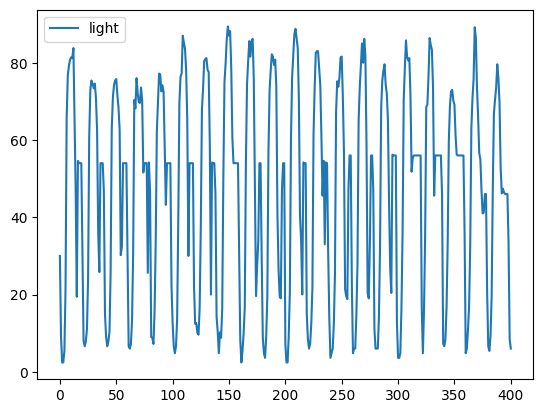

In [3]:
df = pd.read_csv('light-400.csv')
print(len(df))
print(df)
df.plot()

# Split into Train and Validate sets

401
361
40


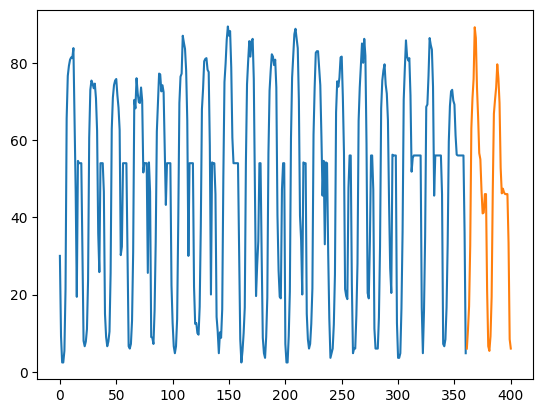

In [4]:
print(len(df))
val_percent = 0.1   # 10 percent of data
val_point = np.round(len(df)*val_percent)
val_index = int(len(df) - val_point)
train = df.iloc[:val_index]
val = df.iloc[val_index:]

print(len(train))
print(len(val))

plt.plot(train)
plt.plot(val)


# Normalise data sets

In [5]:
scaler = MinMaxScaler(copy=True, feature_range=(0, 1))
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_val = scaler.transform(val)

# Your Tasks

*   Using the lecture notebook as a guide, build and train a vanilla RNN, using a sequence length of 20
*   Check your model against the validation data set
*   Use your model to forecast 40 steps into the future

Repeat the above steps for a LSTM



# Things to explore

*  Batch size - Try varying the batch size to, for example, 1 and 10. How does batch size affect model accuracy and training time? Why?

*  Number of RNN layers - what happens if you add a second recurrent layer to your model? Here is the code to do this for a vanilla RNN. The code for a LSTM is similar.
```
rnn_model.add(SimpleRNN(output_space, return_sequences=True, input_shape = (length , n_features)))
rnn_model.add(SimpleRNN(output_space))
```





In [11]:
length = 20
batch_size = 6

generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)
validation_generator = TimeseriesGenerator(scaled_val, scaled_val, length=length, batch_size=batch_size)
print(len(scaled_train))
print(len(scaled_val))
print(generator.length)
print(validation_generator.length)
print(len(generator.data))
print(len(validation_generator.data))


361
40
20
20
361
40


In [13]:
length = 20
batch_size = 6
n_features = 1

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)
validation_generator = TimeseriesGenerator(scaled_val, scaled_val, length=length, batch_size=batch_size)

lstm_model = Sequential()

output_space = length # Same as number of time steps in the training window

lstm_model.add(LSTM(output_space, input_shape=(length, n_features)))

#lstm_model.add(LSTM(output_space, return_sequences=True, input_shape=(length,n_features)))
#lstm_model.add(LSTM(output_space))

lstm_model.add(Dense(1))

lstm_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse')
lstm_model.fit(generator, epochs=200, validation_data=validation_generator, callbacks=[callback])

Epoch 1/200
57/57 [==============================] - 4s 25ms/step - loss: 0.2576 - val_loss: 0.1866
Epoch 2/200
57/57 [==============================] - 1s 15ms/step - loss: 0.2037 - val_loss: 0.1450
Epoch 3/200
57/57 [==============================] - 1s 11ms/step - loss: 0.1615 - val_loss: 0.1120
Epoch 4/200
57/57 [==============================] - 1s 12ms/step - loss: 0.1288 - val_loss: 0.0861
Epoch 5/200
57/57 [==============================] - 1s 13ms/step - loss: 0.1068 - val_loss: 0.0738
Epoch 6/200
57/57 [==============================] - 1s 12ms/step - loss: 0.0962 - val_loss: 0.0700
Epoch 7/200
57/57 [==============================] - 1s 13ms/step - loss: 0.0921 - val_loss: 0.0687
Epoch 8/200
57/57 [==============================] - 1s 14ms/step - loss: 0.0918 - val_loss: 0.0676
Epoch 9/200
57/57 [==============================] - 1s 13ms/step - loss: 0.0892 - val_loss: 0.0666
Epoch 10/200
57/57 [==============================] - 1s 12ms/step - loss: 0.0876 - val_loss: 0.0658

1/1 [==============================] - 0s 27ms/step


<ipython-input-14-d13febb9fa20>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['LSTM Predictions'] = true_predictions


<Axes: >

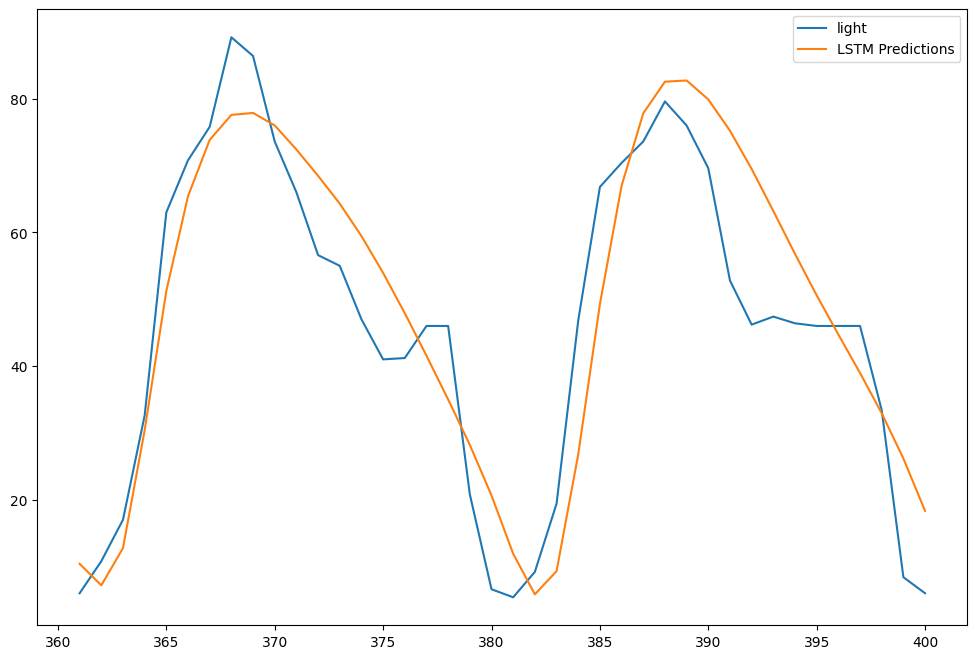

In [14]:
test_predictions = []

first_eval_batch = scaled_train[-length:]

current_batch = first_eval_batch.reshape(1,length,n_features)


for i in range(len(val)):
  current_pred = lstm_model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis = 1)

true_predictions = scaler.inverse_transform(test_predictions)
val['LSTM Predictions'] = true_predictions
val.plot(figsize=(12,8))

In [16]:
full_scaler = MinMaxScaler(copy=True, feature_range=(0, 1))
scaled_full_data = full_scaler.fit_transform(df)

forecast = []

first_eval_batch = scaled_full_data[-length:]

current_batch = first_eval_batch.reshape(1, length, n_features)


for i in range(40):
  current_pred = lstm_model.predict(current_batch)[0]

  forecast.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis = 1)


1/1 [==============================] - 0s 21ms/step
